In [98]:
import pickle
from typing import DefaultDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42



# results_file = open('/Users/duncan/Downloads/meta_perf_vs_num_train.pkl', 'rb')
results_file = open('/Users/duncan/Downloads/meta_perf_vs_num_train_fixed_200trials.pkl', 'rb')  # new file
all_results = pickle.load(results_file)
results_file.close()

In [54]:
### Helper

from matplotlib import transforms


def draw_dodge(*args, **kwargs):
    func = args[0]
    dodge = kwargs.pop("dodge", 0)
    ax = kwargs.pop("ax", plt.gca())
    trans = ax.transData  + transforms.ScaledTranslation(dodge/72., 0,
                                   ax.figure.dpi_scale_trans)
    artist = func(*args[1:], **kwargs)
    def iterate(artist):
        if hasattr(artist, '__iter__'):
            for obj in artist:
                iterate(obj)
        else:
            artist.set_transform(trans)
    iterate(artist)
    return artist


In [63]:
# # (num_trials is just used to verify all evaluations succeeded)
# pct_diff = "perc_diff_from_best_global"
# mae = 'mae'

num_trials=200

models = ['xgboost', 'random', 'knn', 'linear']

In [64]:
metrics = ["mae", "perc_diff_from_best_global"]

results_per_model = {metric: {model: DefaultDict(list) for model in models} for metric in metrics} 
for metric in metrics:
    for dataset in all_results:
        for trial in all_results[dataset]:
            num_train = all_results[dataset][trial]['num_train']
            for model in all_results[dataset][trial]:
                # note: it's not so safe to do this, where we throw away the the num_* and hard-code it later.
                if model in ['num_train', 'num_algs', 'num_feats']: continue
                for n_train, perf in zip(num_train, all_results[dataset][trial][model]):
                    results_per_model[metric][model][n_train].append(perf[metric])



In [94]:
# multiply all numbers by 100 (we want %s, not fractions)

medians = {metric: {} for metric in metrics}
means =  {metric: {} for metric in metrics}
p1s =  {metric: {} for metric in metrics}
p3s =  {metric: {} for metric in metrics}
for  metric in metrics:
    if metric == "perc_diff_from_best_global":
        multiply_factor = 100.0
    else:
        multiply_factor = 1.0
    for model in models:
        means[metric][model] = []
        medians[metric][model] = []
        p1s[metric][model] = []
        p3s[metric][model] = []
        # needs to match the range in the python file
        for n_train in range(2, 20, 2):
            assert len(results_per_model[metric][model][n_train]) == 19 * num_trials, f"for model: {model} and  n_train={n_train}, num-results={len(results_per_model[model][n_train])}"
            means[metric][model].append(multiply_factor * np.mean(results_per_model[metric][model][n_train]))
            medians[metric][model].append(multiply_factor * np.median(results_per_model[metric][model][n_train]))
            p1s[metric][model].append(multiply_factor * np.percentile(results_per_model[metric][model][n_train], 40))
            p3s[metric][model].append(multiply_factor * np.percentile(results_per_model[metric][model][n_train], 60))

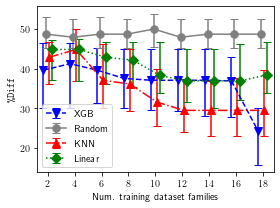

In [99]:
method_dict = {
    "xgboost": {
        "name": "XGB",
        "kwargs": {
            "marker": "v",
            "color": "blue",
            "linestyle": "--",
        }
    },
    "linear": {
        "name": "Linear",
        "kwargs": {
            "marker": "D",
            "color": "green",
            "linestyle": ":",
        }
    },    
    "knn": {
        "name": "KNN",
        "kwargs": {
            "marker": "^",
            "color": "red",
            "linestyle": "-.",
        }
    },
    "random": {
        "name": "Random",
        "kwargs": {
            "marker": "o",
            "color": "gray",
            "linestyle": "-",
        }
    }
}


dodge = np.arange(4,dtype=float)*3
dodge -= dodge.mean()



#### FIRST -- plot %Diff
metric = "perc_diff_from_best_global"
y_axis_label = "\\texttt{\\%Diff}"
# plot with fill between 40-60% of trials

# note: when plotting mae, random and linear are very bad

x = [i for i in range(2, 20, 2)]

fig, ax = plt.subplots(figsize=(4, 3))

for i,model in enumerate(models):
    # plt.plot(x, medians[model], label=method_dict[model]["name"], **method_dict[model]["kwargs"])
    # plt.fill_between(x, p1s[model], p3s[model], alpha=0.1, color=method_dict[model]["kwargs"]["color"])
    yerr = np.array([(x - small, large - x) for x, small, large in zip(medians[metric][model], p1s[metric][model], p3s[metric][model])]).T
    # err_minus = [x - small for m, small in zip(medians[model], p1s[model])]
    # plt.errorbar(x, medians[model], yerr=yerr, capsize=4, **method_dict[model]["kwargs"])
    draw_dodge(ax.errorbar, x, medians[metric][model], yerr=yerr, ax=ax, dodge=dodge[i], capsize=4, markersize=7.5, label=method_dict[model]["name"], **method_dict[model]["kwargs"])

ax.set_xticks(np.arange(2, 19, 2))
plt.legend()
plt.xlabel('Num. training dataset families')
plt.ylabel(y_axis_label)
plt.tight_layout()
plt.savefig('./plot_files/perf_vs_datasets_plot.pdf', bbox_inches="tight", pad_inches=0)
plt.show()



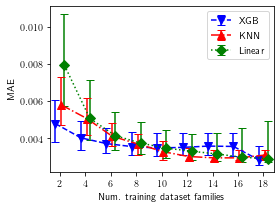

In [100]:

#### SECOND -- plot MAE
metric = "mae"
y_axis_label = "MAE"
# plot with fill between 40-60% of trials

# note: when plotting mae, random and linear are very bad

x = [i for i in range(2, 20, 2)]

fig, ax = plt.subplots(figsize=(4, 3))

for i,model in enumerate(models):
    if model == "random": 
        continue
    # plt.plot(x, medians[model], label=method_dict[model]["name"], **method_dict[model]["kwargs"])
    # plt.fill_between(x, p1s[model], p3s[model], alpha=0.1, color=method_dict[model]["kwargs"]["color"])
    yerr = np.array([(x - small, large - x) for x, small, large in zip(medians[metric][model], p1s[metric][model], p3s[metric][model])]).T
    # err_minus = [x - small for m, small in zip(medians[model], p1s[model])]
    # plt.errorbar(x, medians[model], yerr=yerr, capsize=4, **method_dict[model]["kwargs"])
    draw_dodge(ax.errorbar, x, medians[metric][model], yerr=yerr, ax=ax, dodge=dodge[i], capsize=4, markersize=7.5, label=method_dict[model]["name"], **method_dict[model]["kwargs"])

ax.set_xticks(np.arange(2, 19, 2))
plt.legend()
plt.xlabel('Num. training dataset families')
plt.ylabel(y_axis_label)
plt.tight_layout()
plt.savefig('./plot_files/mae_perf_vs_datasets.pdf', bbox_inches="tight", pad_inches=0)
plt.show()